<a href="https://colab.research.google.com/github/mrpintime/Gaussian-Mixture-Model/blob/main/Image_Dimensionality_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian-Mixture-Model
Created By Moein aka Mrpintime

# Description  

We use Gaussian Mixture Model (GMM) as a clustering algorithm to segmentate the pixels of a picture, and also we replace value of points of each segment with value of corresponded centroid.

We can see how this model help us to reduce volume of a picture but still has enough information from original picture to recognize it.
GMM is a Soft clustering algorithms can cluster data in partially one cluster and partially others.  

We can use a GMM to segment an image into K regions (n_components = K) according to significant colors.

Each pixel would be a data point with three features (r, g, b) (Or 1 feature if greyscale).

In [1]:
import numpy as np
import cv2
from sklearn.mixture import GaussianMixture as GMM
import matplotlib.pyplot as plt

Read image.

In [2]:
img = cv2.imread('/content/img.jpg')

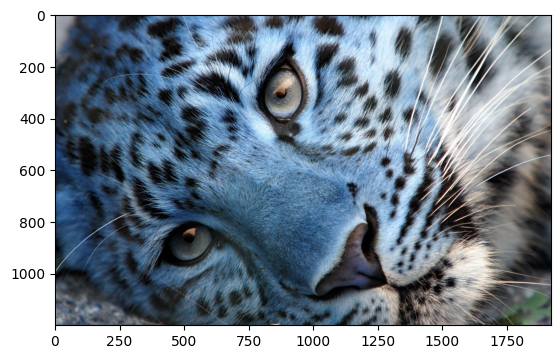

In [3]:
plt.imshow(img)
plt.show()

# Reshape Image

In [4]:
# Thease are data of our picture
img[0:1], img.shape

(array([[[170, 174, 179],
         [167, 171, 176],
         [160, 164, 169],
         ...,
         [176, 185, 194],
         [184, 193, 202],
         [175, 184, 193]]], dtype=uint8),
 (1200, 1920, 3))

If img is greyscale, then change to .reshape(-1, 1):

In [5]:
x = img.reshape(-1, 3)

In [6]:
x.shape

(2304000, 3)

In [7]:
x

array([[170, 174, 179],
       [167, 171, 176],
       [160, 164, 169],
       ...,
       [101, 115, 114],
       [101, 115, 114],
       [101, 115, 114]], dtype=uint8)

The number of components; n > 0, positive integer:


In [8]:
n = 2

In [10]:
gm_model = GMM(n_components=n, covariance_type='full')
gm_model.fit(x)

# predicted each pixels belong to which cluster.
labels = gm_model.predict(x)

# create a matrix with shape of our image sets
segment = np.zeros(x.shape)

#Assign each pixels in corresponded cluster into their centroid value
for label in range(n):
    segment[labels == label] = gm_model.means_[label]

# change shape for save it into picture.
segment = segment.reshape(img.shape).astype(np.uint8)

In [11]:
# write image.
cv2.imwrite(f'/content/gauss-leopard-{n}.jpeg', segment)

True

Let's see our new image

In [12]:
img_2 = cv2.imread('/content/gauss-leopard-2.jpeg')

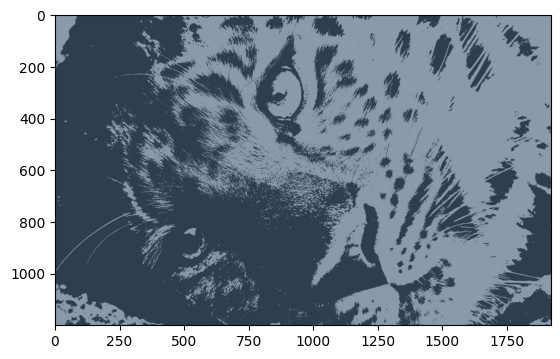

In [13]:
plt.imshow(img_2)
plt.show()